In [95]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'retina'}

In [144]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import scipy.odr as odr
from scipy.optimize import curve_fit
import lmfit
from copy import deepcopy

In [145]:
hubble_constant = 75 * 3.24078e-20
speed_of_light = 3e8

Fitting a six parameter $\Lambda$CDM model
-----------------------------------------

The model is specified as follows:

$$
    H(a) \equiv \frac{\dot{a}}{a} = H_0 \sqrt{ \left [ (\Omega_c + \Omega_b) a^{-3} + \Omega_{rad} a^{-4} + \Omega_k a^{-2} + \Omega_{DE} a^{-3(1+w)} \right ]}~. ~ ~ ~ ~ (1)
$$

We also need to fit for the effective luminosity of the supernovae, using

$$
    f = \frac{L_{peak}}{4\pi\left[R_0\eta\right]^2(1+z)^2}~, ~ ~ ~ ~ (2)
$$

with

$$
    m = m_0 - 2.5\log_{10}(f)~, ~ ~ ~ ~ (3)
$$

and

$$
    R_0\eta = c\int^z_0 \frac{\mathrm{d}z'}{H(z')}~. ~ ~ ~ ~ (4)
$$

which assumes $k=0$ and as such we reduce to a 6 parameter model again. We measure goodness of fit with chi squared:

$$
    \chi^2 = \sum_n \frac{(obs_i - exp_i)^2}{\sigma^2}~. ~ ~ ~ ~ (5)
$$

Below functions are set up to enable us to fit the data to the equations given above.

What about the flux conversion? We have that the $m_0 = -20.45$ for erg cm$^{-2}$ s$^{-1}$ $\r{A}^{-1}$.

To convert this to erg m$^{-1}$ s$^{-1}$ $A^{-1}$, we need to multiply the flux by $10^{-4}$ to get this correct, leading the value of $m_0$ becoming $-20.45 - - 2.5*4 = -10.45$.

In [146]:
def a_of_z(z):
    """Simple function that gives a(z) = 1/(1+z)"""
    return 1./(1+z)

In [147]:
def h_of_a(a, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (1) at the top. Returns H(a)"""
    return H0 * np.sqrt((omega_c+omega_b)*(a**(-3)) + omega_rad*(a**(-4)) + omega_k*(a**(-2)) + omega_de*(a**(-3*(1+w))))

In [148]:
def h_of_z(z, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (1) at the top. Returns H(a)"""
    a = a_of_z(z)
    return h_of_a(a, omega_c, omega_b, omega_rad, omega_k, omega_de, w, H0)

In [149]:
def h_of_z_inverse(z, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """1/h_of_z"""
    return 1/h_of_z(z, omega_c, omega_b, omega_rad, omega_k, omega_de, w, H0)

In [150]:
def f_of_z(z, lpeak, r_eta):
    """Implementation of (2) at the top. Returns flux as a function of redshift"""
    return lpeak/(4*np.pi*((r_eta)**2)*((1+z)**2))

In [151]:
def mag_of_f(f, m0=-20.45):
    """Implementation of (3) at the top. Returns magnitude as a function of flux
    Assumes f given in cgs units"""
    return m0 - 2.5*np.log10(1E-4*f)

In [152]:
def r_eta_int(z, h_of_z_inverse, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (4) at the top. Returns R0 eta as a function of z. h_of_z callable."""
    oarray = np.empty_like(z)
    
    for i in range(len(z)):
        output = si.quad(h_of_z_inverse, 0, z[i], args=(omega_c, omega_b, omega_rad, omega_k, omega_de, w, H0))
        oarray[i] = speed_of_light*output[0]
        
    return oarray

In [153]:
def read_data(fname="data/z_data.csv"):
    """Reads data

    Output
    ------
    z: z array
    m: magnitude array
    m_err: magnitude error array"""
    
    raw = np.loadtxt(fname, delimiter=" ", usecols=(1,2,3))
    return raw[:,0], raw[:,1], raw[:,2]

In [154]:
def chisq(obs, exp, err):
    """Returns the chi squared as in (5) top writing."""
    return ((obs-exp)**2/(err**2))

# How to fit the data?

There needs to be some sort of outline here. What we want is a function that gets magnitude $m$ as a function of $z$ and all of the parameters we care about.

1. Function should have inputs for lpeak, omega_c, omega_b, omega_rad, omega_de and w.
2. Function should pass the latter 5 to r_eta_int to get $R_0 \eta$ as a function of $z$
3. This should be passed to f_of_z to get $f(z, L_{peak}, R_0 \eta)$
4. Pass this to mag_of_f to get $m(z, parameters)$.

We will be using scipy.odr to fit the data in case we have information about uncertainty in $z$.

Issue: **We need to impose that the sum of the $\Omega$s is 1**

In [155]:
def calculated_magnitudes(params, z):
    """Implemenets the outline given above."""
    reta = r_eta_int(z, h_of_z_inverse,
                         omega_c=params['c'].value,
                         omega_b=params['b'].value,  # currently fitting omegalamb
                         omega_rad=params['rad'].value,
                         omega_k=params['k'].value,
                         omega_de=params['de'].value,
                         w=params['w'].value, H0=hubble_constant)
    
    return mag_of_f(f_of_z(z, params['leff'].value, reta))

In [156]:
def for_fitting(params, z, data, errors):
    """Used for fitting the calculated_magnitudes equation with lmfit"""
    return chisq(calculated_magnitudes(params, z), data, errors)

In [157]:
z, mag, mag_err = read_data()

In [158]:
params = lmfit.Parameters()
params.add('leff', value=4e38, vary=True)
#omegas
params.add('omega', value=1., vary=False)
params.add('c', value=0., vary=False, min=0.)  # degenerate with b
params.add('b', value=0.3, vary=True, min=0.)
params.add('rad', value=0., vary=False, min=0.)
params.add('k', value=0., vary=False)  # fixed at 0
params.add('de', value=0.7, vary=True, min=0., max=1., expr="omega-b-rad-k")
params.add('w', value=-1, vary=False)  # don't move me man

out = lmfit.minimize(for_fitting, params, args=(z, mag, mag_err), method='leastsq')

print(for_fitting(params, z, mag, mag_err).sum()/(57))
print(lmfit.fit_report(out))

1.91748571592
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 60
    # variables        = 2
    chi-square         = 826.930
    reduced chi-square = 14.257
[[Variables]]
    leff:    3.0174e+39 +/- 2.14e+38 (7.11%) (init= 4e+38)
    omega:   1 (fixed)
    c:       0 (fixed)
    b:       0.29860746 +/- 0.129140 (43.25%) (init= 0.3)
    rad:     0 (fixed)
    k:       0 (fixed)
    de:      0.70139253 +/- 0.129140 (18.41%)  == 'omega-b-rad-k'
    w:      -1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(leff, b)                   = -0.858 


C:\Miniconda3\envs\env\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


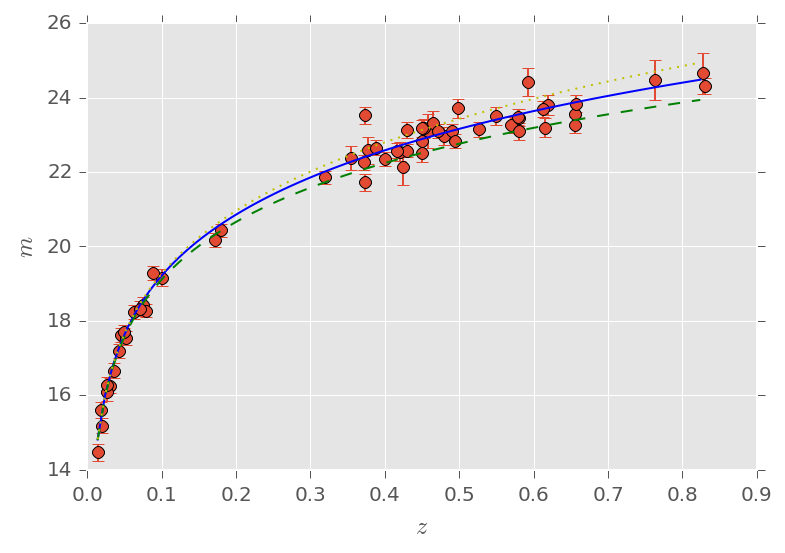

In [159]:

plt.errorbar(z, mag, yerr=mag_err, fmt='o')

z_for_plot = np.arange(min(z), max(z), 0.01)

m_for_plot = calculated_magnitudes(params, z_for_plot)
params_1_0 = deepcopy(params)
params_1_0['b'].value = 1
params_1_0['de'].value = 0
m_for_plot_1_0 = calculated_magnitudes(params_1_0, z_for_plot)
params_0_1 = deepcopy(params)
params_0_1['b'].value = 0
params_0_1['de'].value = 1
m_for_plot_0_1 = calculated_magnitudes(params_0_1, z_for_plot)

plt.plot(z_for_plot, m_for_plot, color='blue')
plt.plot(z_for_plot, m_for_plot_1_0, linestyle='--', color='green')
plt.plot(z_for_plot, m_for_plot_0_1, linestyle=':', color='y')
plt.xlabel("$z$")
plt.ylabel("$m$")
plt.show()

C:\Miniconda3\envs\env\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


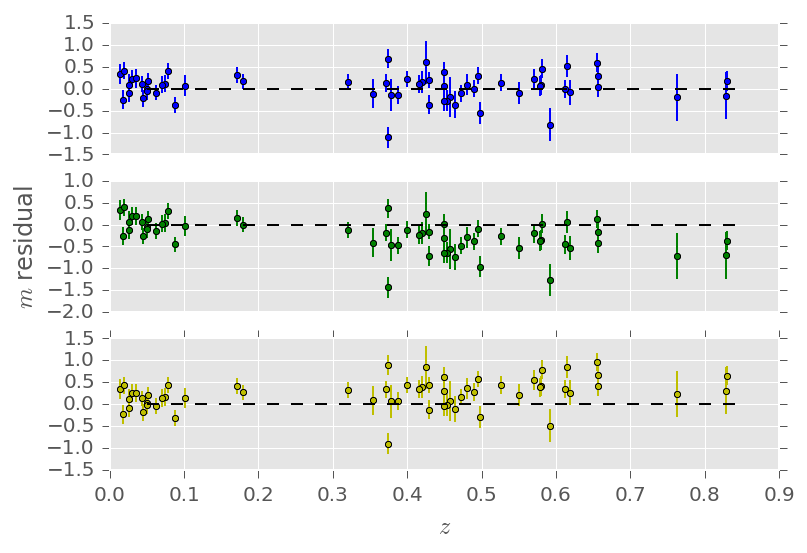

In [160]:
# Residual plot

m_for_res = calculated_magnitudes(params, z)
m_for_res_1_0 = calculated_magnitudes(params_1_0, z)
m_for_res_0_1 = calculated_magnitudes(params_0_1, z)

plt.subplot(311)
plt.errorbar(z, m_for_res - mag, yerr=mag_err, fmt='bo', ms=3, capthick=0)

plt.plot((0.05, 0.85), (0, 0), '--', color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.subplot(312)
plt.errorbar(z, m_for_res_1_0 - mag, yerr=mag_err, fmt='go', ms=3, capthick=0)
plt.plot((0.05, 0.85), (0, 0), '--', color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off




plt.ylabel('$m$ residual')

plt.subplot(313)
plt.errorbar(z, m_for_res_0_1 - mag, yerr=mag_err, fmt='yo', ms=3, capthick=0)
plt.plot((0.05, 0.85), (0, 0), '--', color='black')

plt.xlabel('$z$')

plt.show()